# Introduction #

this project is for the [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition! 



# Step 1 - Imports #


We'll start by importing the packages we used in the project and setting some notebook defaults.

In [1]:

import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')


## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. For the *Ames* competition dataset, we'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for us to get a fresh dataframe whenever we need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

In [2]:
def load_data():
    # Read data
    data_dir = Path("house-prices-advanced-regression-techniques")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test


### Clean Data ###

Some of the categorical features in this dataset have what are apparently typos in their categories:

In [3]:
data_dir = Path("house-prices-advanced-regression-techniques")
df = pd.read_csv(data_dir / "train.csv", index_col="Id")



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
df.MSSubClass.unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40], dtype=int64)

In [6]:
df.Exterior2nd.unique()
# BRK Cmn is written wrong, it's BrkComm

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [7]:
df.Alley.unique()
##nan means that there's no alley access 

array([nan, 'Grvl', 'Pave'], dtype=object)

In [8]:
df.Alley.isnull().sum()

1369

In [9]:
df.LotFrontage.unique()
## nan mean that it's just missing so might impute is with mean or median maybe 

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  nan,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40., 105.,  73.,
        77.,  64.,  94.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.])

In [10]:
df.MasVnrType.unique()
##None means there's is no veneer, but nan is missing values 

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [11]:
df.BsmtQual.unique()
##nan means no basment 

array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object)

In [12]:
df.BsmtCond.unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

In [13]:
df.BsmtExposure.unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [14]:
df.FireplaceQu.unique()
##nan means no fire place 

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [15]:
df.GarageType.unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
      dtype=object)

In [16]:
df.GarageYrBlt.unique()

#nan cause no grg

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

In [17]:
df.PoolQC.unique()

##nan means no pool 

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

In [18]:
df.Fence.unique()

##nan means there's no fence

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [19]:
df.MiscFeature.unique()
##nan means Miscellaneous feature not covered

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

so now we can handle null values as we understand why they are nulls


Comparing these to `data_description.txt` shows us what needs cleaning.

In [20]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    
    df['Alley']= df['Alley'].fillna(0)
    
    df['BsmtQual'] = df['BsmtQual'].replace({"nan":"None"})
    df['BsmtCond'] = df['BsmtCond'].replace({"nan":"None"})
    df['BsmtExposure'] = df['BsmtExposure'].replace({"nan":"None"})
    df['FireplaceQu'] = df['FireplaceQu'].replace({"nan":"None"})
    df['GarageType'] = df['GarageType'].replace({"nan":"None"})
    df['GarageYrBlt'] = df['GarageYrBlt'].replace({"nan":"None"})
    df['GarageFinish'] = df['GarageFinish'].replace({"nan":"None"})
    df['PoolQC'] = df['PoolQC'].replace({"nan":"None"})
    df['Fence'] = df['Fence'].replace({"nan":"None"})
    df['MiscFeature'] = df['MiscFeature'].replace({"nan":"None"})
    
    
    return df


### Encode the Statistical Data Type ###

Pandas has Python types corresponding to the standard statistical types (numeric, categorical, etc.). Encoding each feature with its correct type helps ensure each feature is treated appropriately by whatever functions we use, and makes it easier for us to apply transformations consistently. 

In [26]:

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "LandContour",
                "LotConfig", "Neighborhood", "Condition1", "Condition2", 
                "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", 
                "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", 
                "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 
# Pandas calls the categories "levels"

five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10)) ## from 0 to 9

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    'Alley' : ["Grvl" , "Pave"],
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values, Although we already manually did this, just to make sure.
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}
##this exp is equal to ' for key,value in ordered_levels.items():
    ##orders_levels.key = ['None'] + value }'
    


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df


### Handle Missing Values ###

we will impute with 0, mean, or None depending on wha twe noted previously about the missing data values as most of them are missing for a good reason.

In [27]:
from sklearn.impute import SimpleImputer

def impute(df):
    
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer = imputer.fit(df[['LotFrontage']])
    df['LotFrontage'] = imputer.transform(df[['LotFrontage']])
    for name in df.select_dtypes("number"):
        #df[name + '_was_missing'] = df[name].isnull()
        df[name] = df[name].fillna(0)
        
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df


## Load Data ##

And now we can call the data loader and get the processed data splits:

In [28]:
df_train, df_test = load_data()

## Establish Baseline ##

Finally, let's establish a baseline score to judge our feature engineering against.



In [62]:

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


We can reuse this scoring function anytime we want to try out a new feature set. We'll run it now on the processed data with no additional features and get a baseline score:

In [63]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14130 RMSLE


This baseline score helps us to know whether some set of features we've assembled has actually led to any improvement or not.

# Step 2 - Feature Utility Scores #


In [64]:

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Let's look at our feature scores again:

In [69]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64

You can see that we have a number of features that are highly informative and also some that don't seem to be informative at all (at least by themselves). the top scoring features will usually pay-off the most during feature development. On the other hand, training on uninformative features can lead to overfitting. So, the features with 0.0 scores we'll drop entirely:

In [35]:
def drop_uninformative(df, mi_scores):
    
    return df.loc[:, mi_scores > 0.00]


Removing them does lead to a modest performance gain:

In [70]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

0.13955957380731315

Later, we'll add the `drop_uninformative` function to our feature-creation pipeline.

# Step 3 - Create Features #

Now we'll start developing our feature set.

To make our feature engineering workflow more modular, we'll define a function that will take a prepared dataframe and pass it through a pipeline of transformations to get the final feature set. It will look something like this:


In [71]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X


A label encoding is okay for any kind of categorical feature when you're using a tree-ensemble like XGBoost, even for unordered categories.

## Create Features with Pandas ##


In [40]:
df.YearBuilt.unique()

array([2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939, 1965,
       2005, 1962, 2006, 1960, 1929, 1970, 1967, 1958, 1930, 2002, 1968,
       2007, 1951, 1957, 1927, 1920, 1966, 1959, 1994, 1954, 1953, 1955,
       1983, 1975, 1997, 1934, 1963, 1981, 1964, 1999, 1972, 1921, 1945,
       1982, 1998, 1956, 1948, 1910, 1995, 1991, 2009, 1950, 1961, 1977,
       1985, 1979, 1885, 1919, 1990, 1969, 1935, 1988, 1971, 1952, 1936,
       1923, 1924, 1984, 1926, 1940, 1941, 1987, 1986, 2008, 1908, 1892,
       1916, 1932, 1918, 1912, 1947, 1925, 1900, 1980, 1989, 1992, 1949,
       1880, 1928, 1978, 1922, 1996, 2010, 1946, 1913, 1937, 1942, 1938,
       1974, 1893, 1914, 1906, 1890, 1898, 1904, 1882, 1875, 1911, 1917,
       1872, 1905], dtype=int64)

In [39]:
df.YearRemodAdd.unique()

array([2003, 1976, 2002, 1970, 2000, 1995, 2005, 1973, 1950, 1965, 2006,
       1962, 2007, 1960, 2001, 1967, 2004, 2008, 1997, 1959, 1990, 1955,
       1983, 1980, 1966, 1963, 1987, 1964, 1972, 1996, 1998, 1989, 1953,
       1956, 1968, 1981, 1992, 2009, 1982, 1961, 1993, 1999, 1985, 1979,
       1977, 1969, 1958, 1991, 1971, 1952, 1975, 2010, 1984, 1986, 1994,
       1988, 1954, 1957, 1951, 1978, 1974], dtype=int64)

In [72]:

def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / (df.TotRmsAbvGrd + df.FullBath + df.HalfBath)
    X['ExterOver'] = (df.ExterQual * df.ExterCond )
    X['BSMTOver'] = (df.BsmtQual ) * (df.BsmtCond ) * (df.BsmtExposure)
    X['OverallQualCond'] = df.OverallQual * df.OverallCond
    X["TotalArea"] = (df.FirstFlrSF + df.SecondFlrSF)
    df['BuiltEra'] = pd.cut(df["YearBuilt"], bins = [1800,1970,2000,2020], labels = [0,1,2])
    df['ModEra'] = pd.cut(df["YearRemodAdd"], bins = [1800,1970,2000,2020], labels = [0,1,2])

    
    # This feature ended up not helping performance
    # X["TotalOutsideSF"] = \
    #     df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
    #     df.Threeseasonporch + df.ScreenPorch
    return X


def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("mean")
    return X



## k-Means Clustering ##


In [73]:

cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=25):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=22):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd


## Principal Component Analysis ##


In [74]:

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


In [75]:

def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

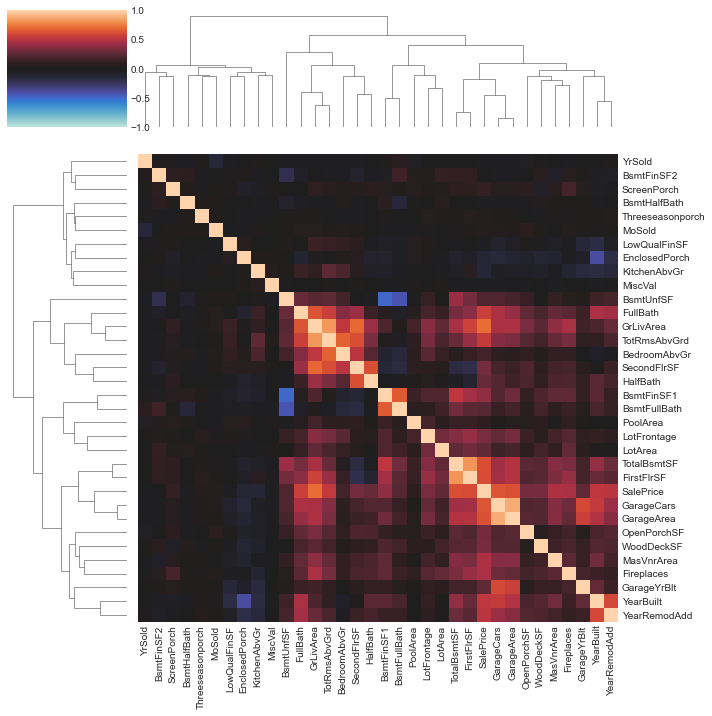

In [76]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)



### PCA Application - Indicate Outliers ###

there was a group of houses in the `Edwards` neighborhood having a `SaleCondition` of `Partial` whose values were especially extreme.

Some models can benefit from having these outliers indicated, which is what this next transform will do.

In [77]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new


## Target Encoding ##

Needing a separate holdout set to create a target encoding is rather wasteful of data.
There is, however, a way you can use target encoding without having to use held-out encoding data. It's basically the same trick used in cross-validation:
1. Split the data into folds, each fold having two splits of the dataset.
2. Train the encoder on one split but transform the values of the other.
3. Repeat for all the splits.

This way, training and transformation always take place on independent sets of data, just like when you use a holdout set but without any data going to waste.


In [78]:

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded




## Create Final Feature Set ##

Now let's combine everything together. Putting the transformations into separate functions makes it easier to experiment with various combinations. 

In [84]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])
        

 
    X = label_encode(X)
    X = drop_uninformative(X, mi_scores)

    # Transformations
    X = X.join(mathematical_transforms(X))
    X = label_encode(X) ## second time to encode the new features from mathematical_transforms
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))  ##didn't end up helping
    X = X.join(group_transforms(X))

    # - Clustering didn't end up helping
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=5)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

0.1333030631522535

# Step 4 - Hyperparameter Tuning #



In [85]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=4,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=6000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=3,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=1,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.11892339695976799

Rather than tuning manually we can use the help of ("optuna") which would get us great results

In [86]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2022-08-12 20:51:52,380] A new study created in memory with name: no-name-6498f63b-4a38-4314-b451-f8617e1cc2c2
[I 2022-08-12 20:52:09,010] Trial 0 finished with value: 0.12340572756815064 and parameters: {'max_depth': 5, 'learning_rate': 0.06952771043244753, 'n_estimators': 6947, 'min_child_weight': 4, 'colsample_bytree': 0.6630204386917455, 'subsample': 0.5671020186021654, 'reg_alpha': 2.8380738066846023, 'reg_lambda': 0.197134228732303}. Best is trial 0 with value: 0.12340572756815064.
[I 2022-08-12 20:52:34,612] Trial 1 finished with value: 0.11817004298112423 and parameters: {'max_depth': 6, 'learning_rate': 0.0017986328370179663, 'n_estimators': 7439, 'min_child_weight': 9, 'colsample_bytree': 0.23397786152939767, 'subsample': 0.5137098734273722, 'reg_alpha': 0.0001886326456403232, 'reg_lambda': 0.006919090528047719}. Best is trial 1 with value: 0.11817004298112423.
[I 2022-08-12 20:52:54,805] Trial 2 finished with value: 0.12656942094113208 and parameters: {'max_depth': 6, 'le

In [87]:
xgb_params # And the winnnnnnnnner

{'max_depth': 7,
 'learning_rate': 0.005166926109478132,
 'n_estimators': 4529,
 'min_child_weight': 6,
 'colsample_bytree': 0.3097684264931783,
 'subsample': 0.6777928288462601,
 'reg_alpha': 0.03915819433041417,
 'reg_lambda': 0.014581928687274611}


# Step 5 - Train Model and Create Submissions #

it's time to create your final predictions! This cell will:


In [88]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
